In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
# import albumentations as A
import cv2
import itertools
import os
import time
from pathlib import Path
# from tqdm.notebook import tqdm
import math
import pickle
from scipy import ndimage
import h5py
import gc
import json

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
# from torchgeometry.losses import dice_loss


# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

torch.manual_seed(3)
# from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
import nii_to_hdf5 as nth

/usr/local/share/anaconda3/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
rootdir = "/data/users/manwatkarc/BraTS2017TestingData"

flair = nth.load_to_numpy(rootdir=rootdir, file_filter='flair.')

GB = nth.load_to_numpy(rootdir=rootdir, file_filter='GlistrBoost.')

In [5]:
GB = np.where(GB > 0, 1, 0)

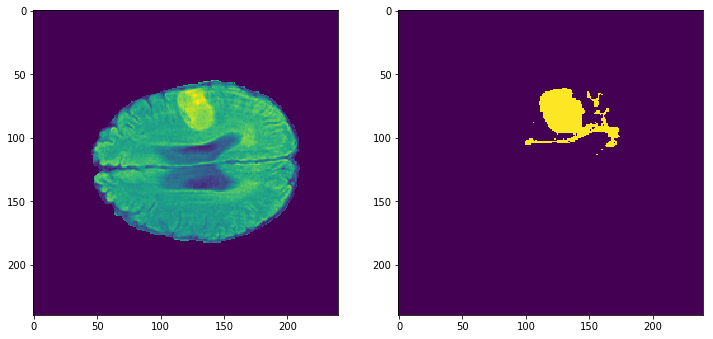

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
z = np.random.randint(80, 105)
img_idx = np.random.randint(len(GB))
ax[0].imshow(flair[img_idx, :, :, z])
ax[1].imshow(GB[img_idx, :, :, z])

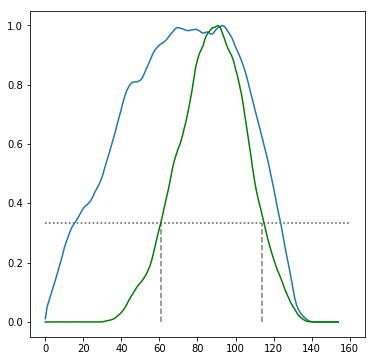

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

variances1 = np.var(np.mean(flair, axis=0), axis=(0, 1))
variances2 = np.var(np.mean(GB, axis=0), axis=(0, 1))

variances1 = variances1/np.max(variances1)
variances2 = variances2/np.max(variances2)

ax.plot(np.arange(variances1.shape[-1]), variances1)
ax.hlines(y=np.max(variances1)/3, xmin=0, xmax=160, color='gray', linestyles='dotted')
ax.plot(np.arange(variances2.shape[-1]), variances2, c='g')
ax.hlines(y=np.max(variances2)/3, xmin=0, xmax=160, color='gray', linestyles='dotted')

ax.vlines(x=61, ymin=0, ymax=np.max(variances1)/3, color='gray', linestyles='dashed')
ax.vlines(x=114, ymin=0, ymax=np.max(variances1)/3, color='gray', linestyles='dashed')

In [8]:
del GB
del flair
gc.collect()

28

In [6]:
class BraTSDataset:
    def __init__(self,
                 rootdir="/data/users/manwatkarc/BraTS2017TestingData",
                 img_label='flair.',
                 masklabel='GlistrBoost.',
                 zmin=65,
                 zmax=115):
        
        self.scans3D = nth.load_to_numpy(rootdir=rootdir, file_filter=img_label)
        self.label3D = nth.load_to_numpy(rootdir=rootdir, file_filter=masklabel)
        
        self.scans3D = self.scans3D[:, :, :, zmin:zmax]
        self.label3D = self.label3D[:, :, :, zmin:zmax]
        
        self.label3D = np.where(self.label3D > 0, 1, 0)
        
        num_img, xlen_img, ylen_img, zlen_img = self.scans3D.shape
        self.scans3D = np.moveaxis(self.scans3D, 3, 1)
        self.scans3D = self.scans3D.reshape(num_img*zlen_img, xlen_img, ylen_img)
        self.label3D = np.moveaxis(self.label3D, 3, 1)
        self.label3D = self.label3D.reshape(num_img*zlen_img, xlen_img, ylen_img)
        
        self.X = torch.from_numpy(self.scans3D)
        self.Y = torch.from_numpy(self.label3D)
        
        del self.scans3D
        del self.label3D
        gc.collect()
        
        
        
    def __getitem__(self, idx):
        img = self.X[idx, :, :]
        mask = self.Y[idx, :, :]
        return torch.unsqueeze(img, 0), torch.unsqueeze(mask, 0) 
    
    def __len__(self):
        return self.X.shape[0]
    
brats_data = BraTSDataset(zmin=0, zmax=150)

In [7]:
x, y = brats_data[100]

In [9]:
os.environ['OMP_NUM_THREADS'] = '1'

In [10]:
len(brats_data)

6450

In [11]:
x.shape

torch.Size([1, 240, 240])

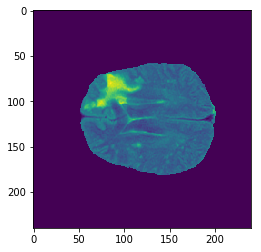

In [12]:
plt.imshow(x[0])

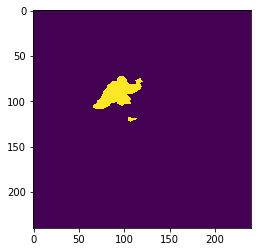

In [13]:
plt.imshow(y[0])

In [14]:
# basic unet with batch normalization
f_size = 7
padding = (int((f_size-1)/2),int((f_size-1)/2))
chs = [32, 64, 128, 256, 512] #, 1024]

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, f_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, f_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
#         x = self.conv1(x.double())
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class unet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # pooling
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # ENCODER
        self.conv00 = ConvBlock(1, 32)
        self.conv10 = ConvBlock(32, 64)
        self.conv20 = ConvBlock(64, 128)
        self.conv30 = ConvBlock(128, 256)
        self.conv40 = ConvBlock(256, 512)
        
        # DECODER
        self.upconv31 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv31 = ConvBlock(2*256, 256)
        self.upconv22 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv22 = ConvBlock(2*128, 128)
        self.upconv13 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv13 = ConvBlock(2*64, 64)
        self.upconv04 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv04 = ConvBlock(2*32, 32)
        
        # final layers
        self.final04 = nn.Conv2d(32, 1, 1)
        self.sigmoid_layer = nn.Sigmoid()
         
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))
        
        # Up-sampling 
        x31 = self.upconv31(x40)
        x31 = self.conv31(torch.cat((x30,x31), dim=1))
        x22 = self.upconv22(x31)
        x22 = self.conv22(torch.cat((x20,x22),dim=1))
        x13 = self.upconv13(x22)
        x13 = self.conv13(torch.cat((x10,x13),dim=1))
        x04 = self.upconv04(x13)
        x04 = self.conv04(torch.cat((x00,x04),dim=1))
        
        # Outputs
        x04 = self.final04(x04)
#         print(x04.shape)
        x04 = self.sigmoid_layer(x04)
        
        return x04
    
# model = unet().cuda()
model = unet().to(device)
# model = unet()#.double()

In [15]:
x, y = next(iter(brats_data))

In [16]:
x.shape, y.shape

(torch.Size([1, 240, 240]), torch.Size([1, 240, 240]))

In [17]:
y_hat = model(torch.unsqueeze(x.float().to(device), 0))
# y_hat = model(x.float().to(device))
y_hat.shape

torch.Size([1, 1, 240, 240])

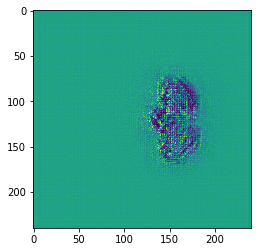

In [18]:
plt.imshow(y_hat.cpu().detach().numpy()[0][0])

In [19]:
def dice_loss(probs, target):
    smooth = 1e-8

    iflat = probs.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection) /
              (iflat.sum() + tflat.sum() + smooth))

crossentropy = F.binary_cross_entropy

In [20]:
learning_rate = 0.001
batch_size = 8
num_epochs = 100

In [21]:
# criterion = nn.CrossEntropyLoss()
mse = nn.MSELoss()
# criterion = torch.nn.BCELoss()
criterion = dice_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
validation_frac = 0.2
train_size = int((1 - validation_frac) * len(brats_data))
validation_size = len(brats_data) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(brats_data, [train_size, validation_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)

In [24]:
# TO DO : Remove all unnecessary type conversions, e.g. .float(), .double(), etc.

In [23]:

metrics_train = {'dice':[], 'crossentropy':[], 'accuracy':[], 'mse': []}
metrics_valid = {'dice':[], 'crossentropy':[], 'accuracy':[], 'mse': []}
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
#             losses_valid = []
#             for validation_data, validation_target in validation_loader:
            validation_data, validation_target = next(iter(validation_loader))
            validation_data, validation_target = validation_data.to(device), validation_target.to(device)
            val_scores = model(validation_data.float())
            val_loss = criterion(val_scores, validation_target.float())
            val_crossentropy = crossentropy(val_scores, validation_target.float())
            val_accuracy = torch.sum((val_scores>0.5).float() == validation_target.float()) / torch.numel(val_scores)
            val_mse = mse(val_scores, validation_target.float())
            metrics_valid['dice'].append(val_loss.item())
            metrics_valid['crossentropy'].append(val_crossentropy.item())
            metrics_valid['accuracy'].append(val_accuracy.item())
            metrics_valid['mse'].append(val_mse.item())
        
        scores = model(data.float())

        loss = criterion(scores, targets.float())
        train_crossentropy = crossentropy(scores, targets.float())
        train_accuracy = torch.sum((scores>0.5).float() == targets.float()) / torch.numel(scores)
        train_mse = mse(scores, targets.float())
        
        metrics_train['dice'].append(loss.item())
        metrics_train['crossentropy'].append(train_crossentropy.item())
        metrics_train['accuracy'].append(train_accuracy.item())
        metrics_train['mse'].append(train_mse.item())
        
        if (not batch_idx) and (not epoch%10):
            print(f'batch: {batch_idx}, epoch: {epoch}, train_loss: {loss.item()}, val_loss: {metrics_valid["dice"][-1]}')
            if not epoch % 20:
                with open(f'train_logs_with_nulls.json', 'w') as f:
                    json.dump(metrics_train, f)

                with open(f'val_logs_with_nulls.json', 'w') as f:
                    json.dump(metrics_valid, f)
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

batch: 0, epoch: 0, train_loss: 0.9956737756729126, val_loss: 0.9815185070037842
batch: 0, epoch: 10, train_loss: 0.17673951387405396, val_loss: 0.12076729536056519
batch: 0, epoch: 20, train_loss: 0.1588672399520874, val_loss: 1.0
batch: 0, epoch: 30, train_loss: 0.07653307914733887, val_loss: 0.30334240198135376
batch: 0, epoch: 40, train_loss: 0.12352591753005981, val_loss: 0.5898085832595825
batch: 0, epoch: 50, train_loss: 0.09718382358551025, val_loss: 0.08572602272033691
batch: 0, epoch: 60, train_loss: 0.05669158697128296, val_loss: 0.06712311506271362
batch: 0, epoch: 70, train_loss: 0.19149476289749146, val_loss: 0.05438786745071411
batch: 0, epoch: 80, train_loss: 0.14847224950790405, val_loss: 0.12954634428024292
batch: 0, epoch: 90, train_loss: 0.03625595569610596, val_loss: 0.05137735605239868


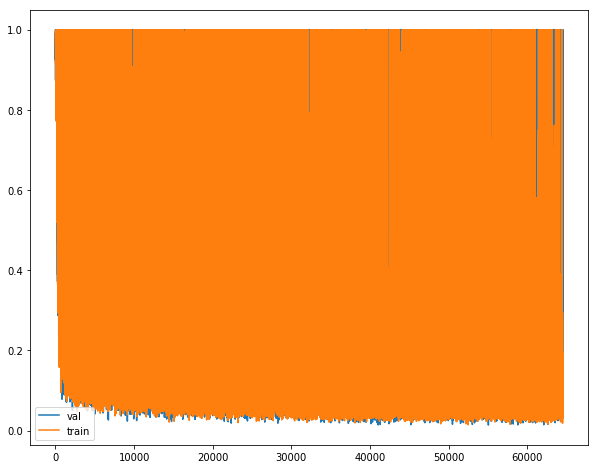

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(metrics_valid["dice"], label='val')
plt.plot(metrics_train["dice"], label='train')
plt.legend()

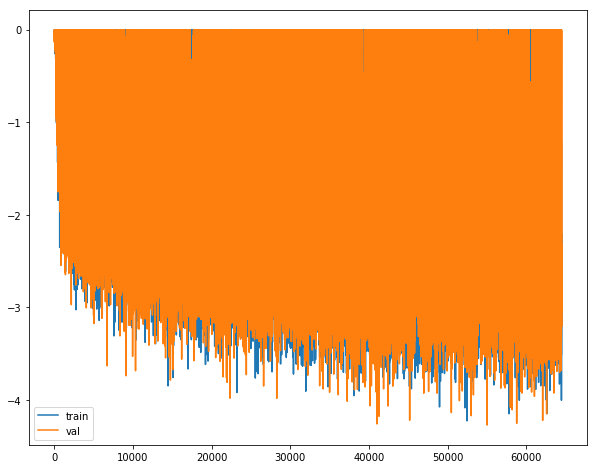

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(np.log(metrics_train["dice"]), label='train')
plt.plot(np.log(metrics_valid["dice"]), label='val')
plt.legend()

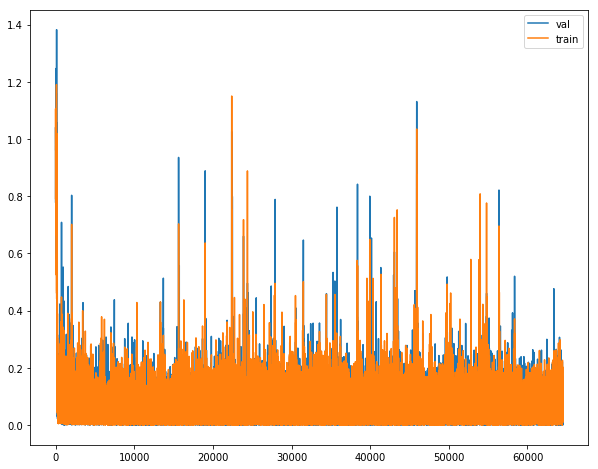

In [26]:
plt.figure(figsize=(10, 8))
plt.plot(metrics_valid["crossentropy"], label='val')
plt.plot(metrics_train["crossentropy"], label='train')
plt.legend()

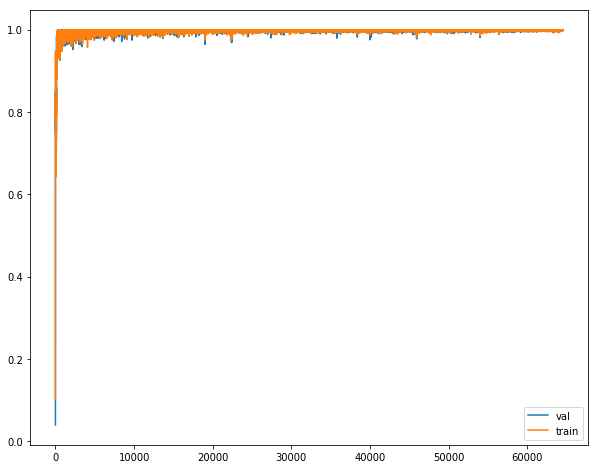

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(metrics_valid["accuracy"], label='val')
plt.plot(metrics_train["accuracy"], label='train')
plt.legend()

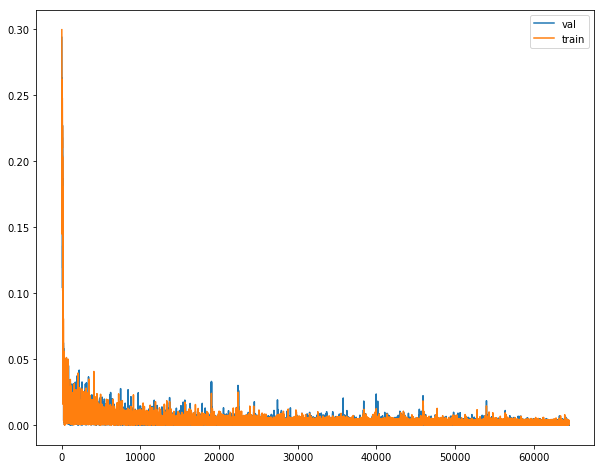

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(metrics_valid["mse"], label='val')
plt.plot(metrics_train["mse"], label='train')
plt.legend()

In [29]:
idx = np.random.randint(len(brats_data))
x, y = brats_data[idx]
y_hat = model(torch.unsqueeze(x.float().to(device), 0))
idx

3225

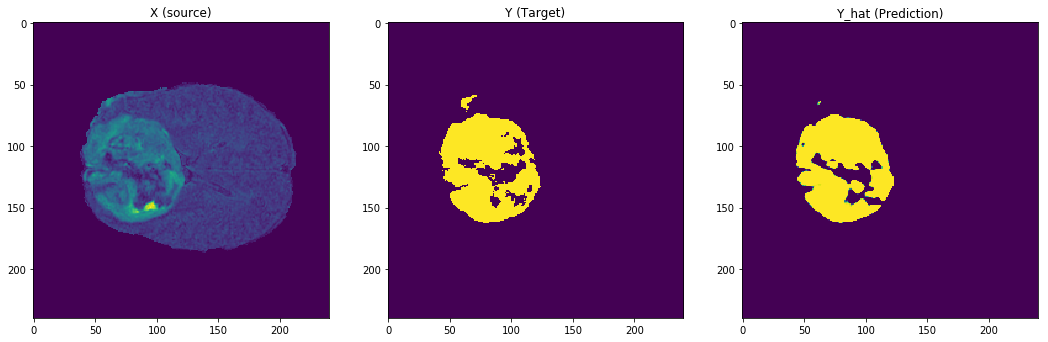

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

ax[0].imshow(x[0])
ax[0].set_title('X (source)');

ax[1].imshow(y[0])
ax[1].set_title('Y (Target)');

ax[2].imshow(y_hat.cpu().detach().numpy()[0][0])
ax[2].set_title('Y_hat (Prediction)');


In [31]:
torch.save(model.state_dict(), '/data/users/manwatkarc/with_nulls_simple_unet.pt')